In [97]:
import Pkg; Pkg.add("Plots"); Pkg.add("BenchmarkTools");using BenchmarkTools

   Resolving package versions...
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`


In [1]:
# Zdefiniowanie typów abstrakcyjnych

abstract type Node end
abstract type Operator end
abstract type LeafNode <: Node end

In [2]:
# Zdefiniowanie struktury Variabe - liść

mutable struct Variable{T} <: LeafNode
    value::T
    grad::T
    Variable(val::T) where T          = new{T}(val, zero(val))
    Variable(val::T, grad::T) where T = new{T}(val, grad)
end

In [3]:
# Zdefiniowanie struktury operatora

struct Method{OT} <: Operator
    f::OT
end

struct Broadcasted{OT} <: Operator
    f::OT
end

In [4]:
# Zdefiniowane struktury węzła obliczeniowego

struct ComputableNode{OT <: Operator, AT <: Tuple, KT <: NamedTuple} <: Node
    op::OT
    args::AT
    kwargs::KT
end
ComputableNode(op::Function, args, kwargs) = ComputableNode(Method(op), args, kwargs)
ComputableNode(op, args)                   = ComputableNode(op, args, NamedTuple())

ComputableNode

In [5]:
# Zdefiniowanie struktury węzła kieszeniującego

mutable struct CachedNode{NT <: Node, OUT} <: Node
    node::NT
    out::OUT
end

function CachedNode(op, args...; kwargs...)
    node = ComputableNode(op, args, kwargs.data)
    out  = forward(node)
    CachedNode(node, out)
end

CachedNode

In [6]:
arg(x::ComputableNode, i::Int) = x.args[i]
args(x::ComputableNode) = x.args
kwargs(x::ComputableNode) = x.kwargs
operator(x::ComputableNode) = x.f

arg(x::CachedNode, i::Int) = x.node.args[i]
args(x::CachedNode) = x.node.args
kwargs(x::CachedNode) = x.node.kwargs
operator(x::CachedNode) = x.node.f

operator (generic function with 2 methods)

In [7]:
import Base: show
show(io::IO, x::Method)         = print(io, "fn ",  x.f);
show(io::IO, x::Operator)       = print(io, "op ",  x.f);
show(io::IO, x::Variable)       = print(io, "var ", x.value);
show(io::IO, x::CachedNode)     = print(io, "{cached (", x.node, ") => ", x.out, "}");
show(io::IO, x::ComputableNode) = print(io, "[", x.op, "](", x.args, ")");

In [8]:
forward(x) = x
forward(leaf::LeafNode) = value(leaf)
forward(node::ComputableNode) = forward(node.op, map(forward, node.args)...; map(forward, node.kwargs)...)
forward(cached::CachedNode) = (cached.out = forward(cached.node))
forward(op::Broadcasted, args...) = Broadcast.broadcasted(op.f, args...)
forward(op::Operator, args...; kwargs...) = op.f(args...; kwargs...)
forward(x::NT) where {NT <: Node} = error("forward method is not implemented for node type: $NT")

forward (generic function with 7 methods)

In [9]:
value(x) = x
value(x::Variable) = x.value
value(x::CachedNode) = value(x.out)
value(x::T) where {T <: Node} = error("Expected value in this node $x of type $T
 check if you defined a non-cached node
 or overload value function for your node.")

value (generic function with 4 methods)

In [10]:
function backward(x::Variable, grad)
    if isdefined(x, :grad)
        x.grad+= grad
    else
        x.grad = grad
    end
    nothing
end

function backward(node::CachedNode, f, grad)
    grad_inputs = gradient(node, grad)
    for (each, each_grad) in zip(args(node), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

function backward(cached::CachedNode, op::Broadcasted, grad)
    grad_inputs = gradient(cached, grad)
    for (each, each_grad) in zip(args(cached), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

backward(cached::CachedNode) = backward(cached, 1.0)
backward(cached::CachedNode, grad) = backward(cached, cached.node.op, grad)
backward(cached::CachedNode, op::Method, grad) = backward(cached, op.f, grad)
backward(cached::CachedNode, ::typeof(Broadcast.materialize), grad) = backward(arg(cached, 1), grad)

backward (generic function with 7 methods)

In [11]:
gradient(x::CachedNode, grad) = gradient(x.node.op, grad, x.out, map(value, x.node.args)...; map(value, x.node.kwargs)...)
gradient(x::Operator,   grad, out, args...; kwargs...) = gradient(x.f, grad, out, args...; kwargs...)
gradient(op, grad, out, args...; kwargs...) = error("gradient of operator $op is not defined\n
 Possible Fix:\n
 define one of the following:\n
 1. gradient(::typeof($op), grad, out, args...; kwargs...)\n
 2. gradient(op::Method{typeof($op)}, grad, out, args...; kwargs...)\n
 3. gradient(op::Broadcasted{typeof($op)}, grad, out, args...; kwargs...)\n")

gradient (generic function with 3 methods)

In [12]:
# Przeciążanie operatorów

import Base: +, -, *, /
+(x::Node) = CachedNode(+, x)
-(x::Node) = CachedNode(-, x)
gradient(::typeof(+), grad, output, x) = (grad * 1, )
gradient(::typeof(-), grad, output, x) = (grad *-1, )
+(x::Node, y::Node) = CachedNode(+, x, y)
-(x::Node, y::Node) = CachedNode(-, x, y)
*(x::Node, y::Node) = CachedNode(*, x, y)
/(x::Node, y::Node) = CachedNode(/, x, y)
gradient(::typeof(+), grad, output, x, y) = (grad * one(x),   grad * one(y))
gradient(::typeof(-), grad, output, x, y) = (grad * one(x),   grad *-one(y))
gradient(::typeof(*), grad, output, x, y) = (grad * y,        grad * x)
gradient(::typeof(/), grad, output, x, y) = (grad * one(x)/y, grad *-x/y/y)

gradient (generic function with 9 methods)

In [13]:
# Przeciążanie funkcji

import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Node)  = CachedNode(abs, x)
sin(x::Node)  = CachedNode(sin, x)
cos(x::Node)  = CachedNode(cos, x)
tan(x::Node)  = CachedNode(tan, x)
exp(x::Node)  = CachedNode(exp, x)
sqrt(x::Node) = CachedNode(sqrt, x)
isless(x::Node, y::Node) = isless(value(x), value(y))
gradient(::typeof(abs), grad, output, x)  = (grad * sign(x), )
gradient(::typeof(sin), grad, output, x)  = (grad * cos(x), )
gradient(::typeof(cos), grad, output, x)  = (grad *-sin(x), )
gradient(::typeof(tan), grad, output, x)  = (grad *(tan(x)^2 + 1), )
gradient(::typeof(exp), grad, output, x)  = (grad * exp(x), )
gradient(::typeof(sqrt), grad, output, x) = (grad * 0.5/sqrt(x), )

gradient (generic function with 15 methods)

In [14]:
# Definicje konwersji i promocji
import Base: convert, promote_rule
convert(::Type{Variable{T}}, x::Number) where T   = Variable(convert(T, x))
convert(::Type{Variable{T}}, x::Variable) where T = Variable(convert(T, x.value), convert(T, x.grad))
promote_rule(::Type{Variable{T}}, ::Type{R}) where {T,R} = Variable{promote_type(R,T)}

promote_rule (generic function with 125 methods)

In [15]:
struct ComputGraphStyle <: Broadcast.BroadcastStyle end
Base.BroadcastStyle(::Type{<:Node}) = ComputGraphStyle()
Broadcast.BroadcastStyle(s::ComputGraphStyle, x::Broadcast.BroadcastStyle) = s
Broadcast.broadcasted(::ComputGraphStyle, f, args...) = CachedNode(Broadcasted(f), args...)
Broadcast.broadcastable(x::Node) = x
Broadcast.materialize(x::Node) = CachedNode(Broadcast.materialize, x)
Base.similar(x::Node)                                      = Variable(similar(value(x)))
Base.similar(x::Node, dims::Dims)                          = Variable(similar(value(x), dims))
Base.similar(x::Node, eltype::Type{S}, dims::Dims) where S = Variable(similar(value(x), eltype, dims))

In [16]:
gradient(::Broadcasted{typeof(+)}, grad, output, x)    = @. (grad * 1, )
gradient(::Broadcasted{typeof(-)}, grad, output, x)    = @. (grad *-1, )
gradient(::Broadcasted{typeof(+)}, grad, output, x, y) = @. (grad * one(x),   grad * one(y))
gradient(::Broadcasted{typeof(-)}, grad, output, x, y) = @. (grad * one(x),   grad *-one(y))
gradient(::Broadcasted{typeof(*)}, grad, output, x, y) = @. (grad * y,        grad * x)
gradient(::Broadcasted{typeof(/)}, grad, output, x, y) = @. (grad * one(x)/y, grad *-x/y/y)
gradient(::Broadcasted{typeof(abs)}, grad, output, x)  = @. (grad * sign(x), )
gradient(::Broadcasted{typeof(sin)}, grad, output, x)  = @. (grad *  cos(x),  )
gradient(::Broadcasted{typeof(cos)}, grad, output, x)  = @. (grad * -sin(x), )
gradient(::Broadcasted{typeof(tan)}, grad, output, x)  = @. (grad * (tan(x)^2 + 1), )
gradient(::Broadcasted{typeof(exp)}, grad, output, x)  = @. (grad *  exp(x), )
gradient(::Broadcasted{typeof(sqrt)}, grad, output, x) = @. (grad *.5/sqrt(x), )

gradient (generic function with 27 methods)

In [32]:
# FUNKCJE OBLICZENIOWE - przyjmujące wektor argumentów
# 1) Funkcja wykładnicza
# 2) Funkcja sinus/cosinus
# 3) Funkcja ReLu
# 4) Funkcja softmax
# 5) Funkcja złożona - sin(x^2)

In [269]:
# Ad 1 - Funkcja wykładnicza

x = Variable(rand(Float64,100))
z = exp.(x)
y = @benchmark backward(z)
# @show x.grad
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  1.75 KiB
  allocs estimate:  2
  --------------
  minimum time:     518.229 ns (0.00% GC)
  median time:      537.500 ns (0.00% GC)
  mean time:        642.018 ns (5.71% GC)
  maximum time:     9.522 μs (85.98% GC)
  --------------
  samples:          10000
  evals/sample:     192

In [270]:
# Ad 2.1 Funkcja sinus

x = Variable(rand(Float64,100))
z = sin.(x)
y = @benchmark backward(z)
# @show x.grad
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  1.75 KiB
  allocs estimate:  2
  --------------
  minimum time:     547.568 ns (0.00% GC)
  median time:      561.622 ns (0.00% GC)
  mean time:        665.321 ns (5.41% GC)
  maximum time:     8.144 μs (89.26% GC)
  --------------
  samples:          10000
  evals/sample:     185

In [272]:
# Ad 2.2 Funkcja cosinus

x = Variable(rand(Float64,100))
z = cos.(x)
y = @benchmark backward(z)
# @show x.grad
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  1.75 KiB
  allocs estimate:  2
  --------------
  minimum time:     482.051 ns (0.00% GC)
  median time:      507.692 ns (0.00% GC)
  mean time:        603.907 ns (6.31% GC)
  maximum time:     13.928 μs (91.09% GC)
  --------------
  samples:          10000
  evals/sample:     195

In [289]:
# Ad 3 Funkcja ReLu


#x = Variable(collect(1.0:0.1:+1.0))
#x = Variable(rand(Float64,100))
x = Variable(rand(Float64, 2))
f(x) = x > zero(x) ? x : zero(x)
z = f.(x)
#ReLu(x) = max(zero(x), x)
#z = f.(x)
backward(z)

LoadError: gradient of operator f is not defined

 Possible Fix:

 define one of the following:

 1. gradient(::typeof(f), grad, out, args...; kwargs...)

 2. gradient(op::Method{typeof(f)}, grad, out, args...; kwargs...)

 3. gradient(op::Broadcasted{typeof(f)}, grad, out, args...; kwargs...)


In [259]:
# Ad 4 Funkcja softmax

x = Variable(rand(Float64,10))
softmax(x)  =  exp.(x) ./ sum(exp.(x))
z = softmax.(x)
backward(z)
x.grad

LoadError: MethodError: no method matching iterate(::CachedNode{ComputableNode{Method{typeof(Base.Broadcast.materialize)}, Tuple{CachedNode{ComputableNode{Broadcasted{typeof(exp)}, Tuple{Variable{Vector{Float64}}}, NamedTuple{(), Tuple{}}}, Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(exp), Tuple{Vector{Float64}}}}}, NamedTuple{(), Tuple{}}}, Vector{Float64}})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

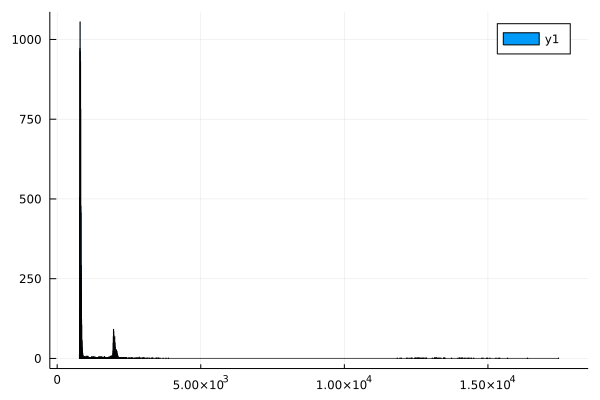

In [286]:
# Ad 5 Funkcja złożona sin(x^2)
x = Variable(rand(Float64, 100))
z = sin.(x.*x)
y = @benchmark backward(z)
# @show x.grad
#mean(y.times)

In [140]:
# Definicja funkcji zwracającej macierz Jacobiego 

J_reverse = function jacobian_back_diff(f::Vector, args::Vector{T}) where {T <:Number}
    jcb_r = Matrix{T}[]
    jcb_m = Matrix{T}[]
    for i=1:length(f)
        gradients = Float64[]
        variables = Variable.(args)
        backward(f[i](variables))
        for variable in variables
            push!(gradients, variable.grad)
        end
        push!(jcb_r, gradients[:,:])
    end
    jcb_m = hcat(jcb_r...)
    transpose(jcb_m)
end
    

jacobian_back_diff (generic function with 1 method)

In [146]:
n = 2
i = 1
while i <=10
    vector1 = rand(Float64, n)
    i += 1
    n += 2
end

1
2
3
4
5
6
7
8
9
10


In [187]:
mean_t = []

Any[]

In [218]:
vector1 = rand(Float64, 30)
f(x::Vector) = sin(x[1]*x[2])
a = @benchmark jacobian_back_diff([f], vector1)
#m = mean(a.times)
#push!(mean_t, m)



BenchmarkTools.Trial: 
  memory estimate:  7.06 KiB
  allocs estimate:  228
  --------------
  minimum time:     7.275 μs (0.00% GC)
  median time:      8.025 μs (0.00% GC)
  mean time:        9.252 μs (6.16% GC)
  maximum time:     1.192 ms (98.49% GC)
  --------------
  samples:          10000
  evals/sample:     4

In [276]:
x = [2:2:30]
mean_t_reverse = [457.60120331950196, 744.0609090909091, 1079.5298648648647, 1412.328, 1859.418, 2247.663, 2642.8422222222225, 3008.519999999999, 3400.8355555555554, 3935.27, 4670.15625, 5443.152857142856, 6507.871666666667, 7750.98, 8253.9375]

15-element Vector{Float64}:
  457.60120331950196
  744.0609090909091
 1079.5298648648647
 1412.328
 1859.418
 2247.663
 2642.8422222222225
 3008.519999999999
 3400.8355555555554
 3935.27
 4670.15625
 5443.152857142856
 6507.871666666667
 7750.98
 8253.9375

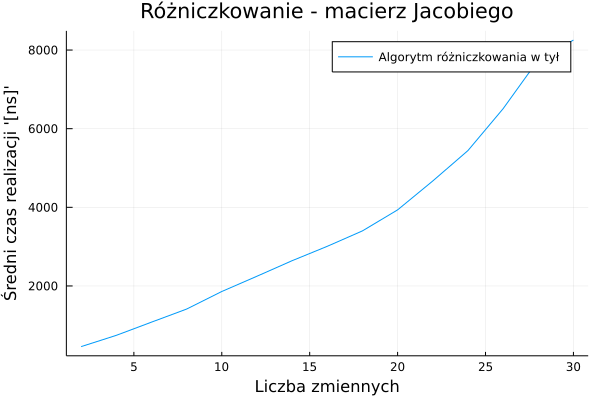

In [277]:
using Plots
plot(x, mean_t_reverse, title = "Różniczkowanie - macierz Jacobiego", label = "Algorytm różniczkowania w tył" )

xaxis!("Liczba zmiennych")
yaxis!("Średni czas realizacji '[ns]'")

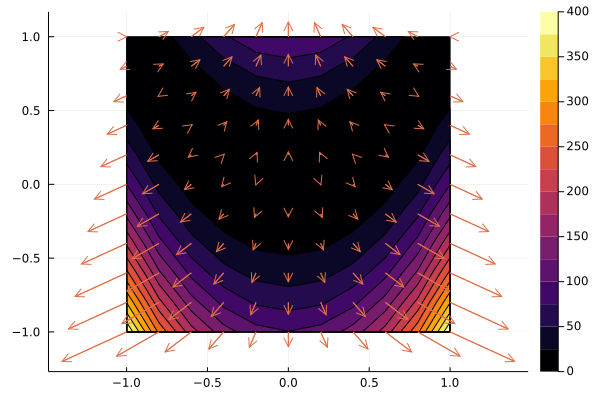

In [100]:
# Funkcja rosenbrocka
using Plots

rosenbrock(x, y) = (Variable(1.0) - x*x) + Variable(100.0)*(y - x*x)*(y-x*x)
v = -1:.2:+1
n = length(v)
xv = repeat(v, inner=n)
yv = repeat(v, outer=n)

function fval(f, xv, yv)
    x, y = Variable(xv), Variable(yv)
    z = f(x, y)
    value(z)
end

function fgrad(f, xv, yv)
    x, y = Variable(xv), Variable(yv)
    z = f(x,y)
    backward(z)
    5e-4x.grad, 5e-4y.grad
end

zv = fval.(rosenbrock, xv, yv)
dz = fgrad.(rosenbrock, xv[:], yv[:])

zv = reshape(zv, n, n)
contour(v, v, zv, fill=true)
quiver!(xv[:], yv[:], gradient=dz)

function rosenbrock_gradient()
    zv = fval.(rosenbrock, xv, yv)
    dz = fgrad.(rosenbrock, xv[:], yv[:])

end

In [284]:
a = @benchmark rosenbrock_gradient()


BenchmarkTools.Trial: 
  memory estimate:  192.48 KiB
  allocs estimate:  7391
  --------------
  minimum time:     92.900 μs (0.00% GC)
  median time:      96.800 μs (0.00% GC)
  mean time:        112.996 μs (9.29% GC)
  maximum time:     3.493 ms (96.53% GC)
  --------------
  samples:          10000
  evals/sample:     1